In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [35]:
#import sklearn package details
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# load the data
df = pd.read_csv('creditcard.csv')

In [4]:
# Exploratory Data Analysis
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
print(df.shape)
print(df.describe())

#Data seems to have had PCA dimensionality reduction for privacy reasons.
#All cols have ~284K rows - good as no data missing
#Class col has Min and Max of 0 and 1. 1 = Fraud and 0 = Legit transactions
# Mean = ~0 for class. => There are way more legit transactions vs. fraud transactions.Hence,anomaly detection is a good option

(284807, 31)
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271

In [12]:
# Because there are ~284K lines, taking a random sample to work on the model

dfs = df.sample(frac = 0.2, random_state = 1)

In [13]:
dfs.shape

(56961, 31)

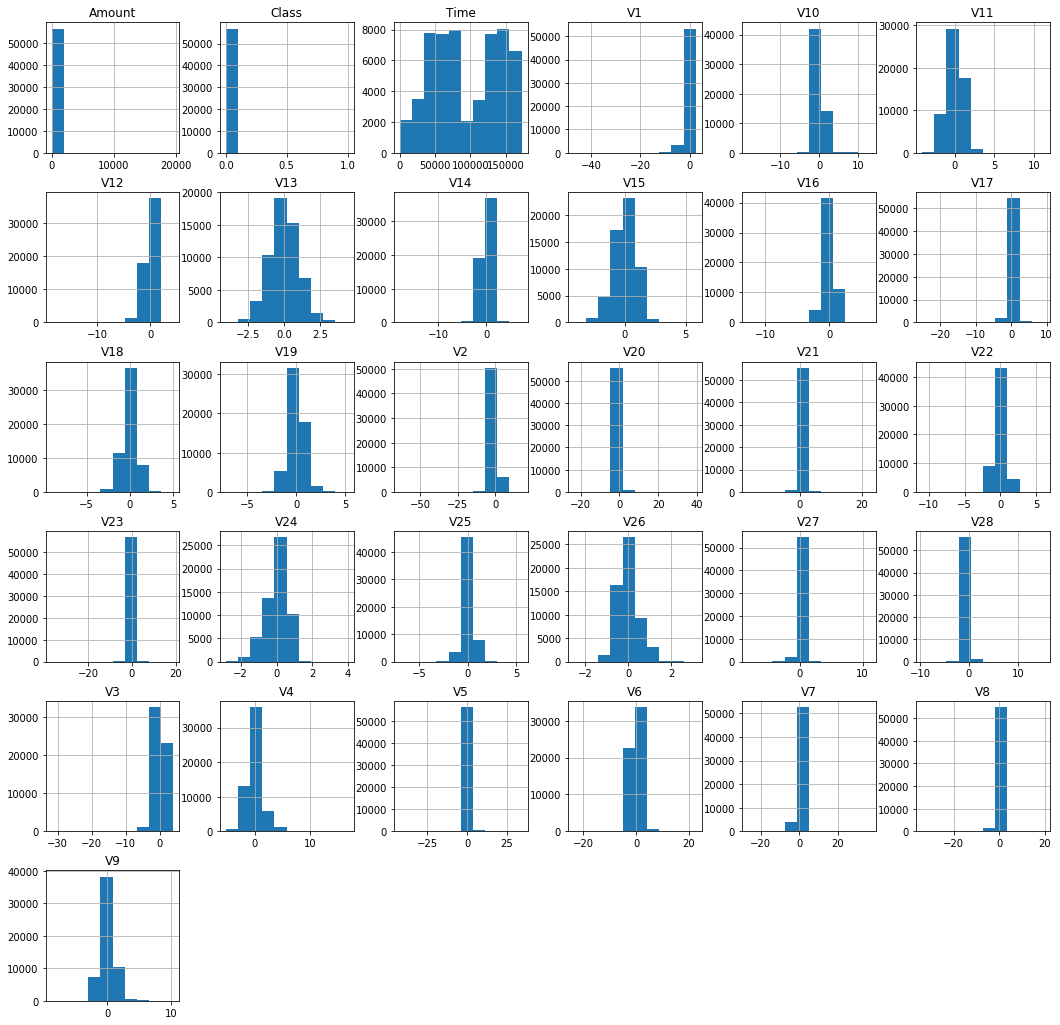

<Figure size 432x288 with 0 Axes>

In [17]:
#Plot histogram of each parameter
dfs.hist(figsize = (18,18))
plt.show()
plt.tight_layout()

In [23]:
dfs[(dfs['Class'] == 1)].describe() # of the sample size of 56,951 we have 87 rows that are fraudulent

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,...,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.0
mean,82274.436782,-3.966748,3.013645,-6.277781,4.300861,-2.744899,-1.327759,-4.482095,1.117319,-2.185587,...,0.527209,-0.032778,-0.239028,-0.025769,0.102553,0.005415,0.309924,0.069768,157.767126,1.0
std,49640.586850,6.433207,3.447350,6.409217,2.771470,4.850325,1.658734,6.008972,4.616546,2.426090,...,1.768167,0.891053,2.220961,0.495020,0.826562,0.445821,1.070808,0.536416,334.479095,0.0
min,7610.000000,-29.876366,-7.159042,-30.558697,-0.755458,-21.665654,-5.140999,-21.922811,-15.415385,-8.739670,...,-6.389132,-2.797150,-19.254328,-1.201685,-4.781606,-1.152671,-3.765371,-1.495006,0.000000,1.0
25%,41275.000000,-5.120489,1.173094,-7.560472,2.084041,-3.613861,-2.214030,-6.134055,-0.080452,-3.739357,...,-0.069314,-0.500717,-0.280829,-0.355814,-0.170612,-0.297964,0.002821,-0.080243,1.000000,1.0
50%,76857.000000,-2.003460,2.500224,-4.484728,4.028571,-1.237055,-1.413476,-2.306689,0.555088,-1.878832,...,0.454032,-0.053812,-0.072173,0.042640,0.139721,-0.007772,0.423620,0.121065,17.390000,1.0
75%,127345.000000,0.340009,3.993759,-2.248914,5.913397,0.564937,-0.406674,-0.716581,1.347260,-0.110442,...,1.117264,0.584799,0.314334,0.380687,0.519929,0.278710,0.758747,0.354159,139.155000,1.0
max,170348.000000,2.132386,16.434525,1.031165,11.824990,2.640750,2.914673,5.802537,19.587773,1.460381,...,8.280439,2.941475,2.661291,1.091435,2.156042,1.207731,3.052358,1.779364,2125.870000,1.0


In [27]:
# To show it a little better
Fraud = dfs[(dfs['Class'] == 1)]
Valid = dfs[(dfs['Class'] == 0)]

Fraud_fra = (len(Fraud)/float (len(Fraud)+len(Valid)))*100
print('Fraud Case %: ',Fraud_fra)

print ('Fraud Cases: {}'.format(len(Fraud)))
print ('Valid Cases: {}'.format(len(Valid)))

Fraud Case %:  0.15273608258281984
Fraud Cases: 87
Valid Cases: 56874


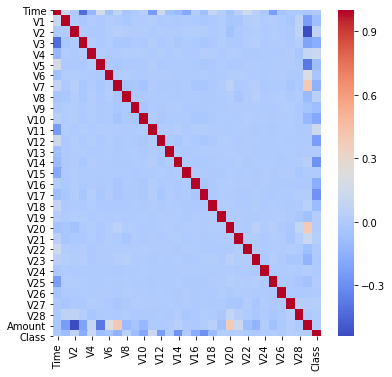

In [28]:
# Building a correlation matrix to see any correlation in the dataset
fig,axes = plt.subplots(1,1,figsize = (6,6))
dfc = dfs.corr() #remember to correlate the data for heat maps
sns.heatmap(dfc, cmap = 'coolwarm')
# Does not seem to have any strong correlation between variables

In [38]:
# Modifying the dataset to X and y

X = dfs.drop('Class',axis =1)
y = dfs['Class']

print (X.shape)
print (y.shape)

(56961, 30)
(56961,)


In [36]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [40]:
# Specifying the LocalOutlierFactor Model
outlier_fraction = len(Fraud)/len(Valid)
LOF = LocalOutlierFactor(n_neighbors=20,contamination = outlier_fraction)

#Fit the Model
y_pred = LOF.fit_predict(X) #Since this is unsupervised learning, we dont want to show y values to model
scores_pred = LOF.negative_outlier_factor_

In [46]:
#Reshape y_pred to compare it to our Class variables (0 = Legit and 1 = Fraud).
# as y_pred gives 1 = Legit and -1 = Fraud (property of Local Outlier Factor)

y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

n_errors = (y_pred != y).sum()
print(n_errors)

87


In [47]:
print (confusion_matrix(y,y_pred))
print('\n')
print (classification_report(y,y_pred))

[[56874     0]
 [   87     0]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.00      0.00      0.00        87

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961



C:\Users\bishnu.mohanty\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
